In [1]:
import sys
sys.path

['C:\\Users\\Brandon\\OneDrive\\TensorFlow Projects\\Anime GAN',
 'C:\\Users\\Brandon\\miniconda3\\envs\\tensorflowenv\\python37.zip',
 'C:\\Users\\Brandon\\miniconda3\\envs\\tensorflowenv\\DLLs',
 'C:\\Users\\Brandon\\miniconda3\\envs\\tensorflowenv\\lib',
 'C:\\Users\\Brandon\\miniconda3\\envs\\tensorflowenv',
 '',
 'C:\\Users\\Brandon\\miniconda3\\envs\\tensorflowenv\\lib\\site-packages',
 'C:\\Users\\Brandon\\miniconda3\\envs\\tensorflowenv\\lib\\site-packages\\win32',
 'C:\\Users\\Brandon\\miniconda3\\envs\\tensorflowenv\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\Brandon\\miniconda3\\envs\\tensorflowenv\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\Brandon\\miniconda3\\envs\\tensorflowenv\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\Brandon\\.ipython']

How to get GPU working (Holy crap its a pain in the ass ... this was the best tutorial): https://www.youtube.com/watch?v=qrkEYf-YDyI

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.test.gpu_device_name()

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5261719418062933200
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7045749146
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13800582766696472464
physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:2b:00.0, compute capability: 7.5"
]


'/device:GPU:0'

If everything worked ... the above should be able to print out the name of your GPU and the default name should be
> '/device:GPU:0'

In [3]:
import numpy as np
import glob
import os
import PIL
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from IPython import display

Example to follow: https://www.tensorflow.org/tutorials/generative/dcgan

Load dataset

In [4]:
%%time
imgs = glob.glob("images\\*.jpg") #Grab all .jpg files in the image folder

data = []
for img in imgs:
    data.append(np.array(PIL.Image.open(img,"r"))) #Open image, convert to np.array, append to list
    
#Display basic info
print("There are %d total images"%len(data))

KeyboardInterrupt: 

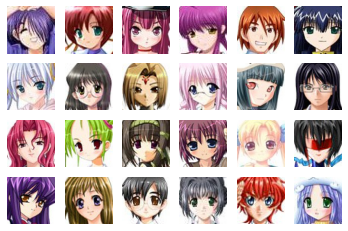

In [17]:
#Display some data
fig, axs = plt.subplots(4,6)
for i in range(4*6):
    ax = plt.subplot(4,6,i+1)
    ax.imshow(data[i])
    ax.axis("off")

Preprocess Data

In [18]:
print("Display shape of 5 random images")
for i in range(5):
    print(data[np.random.randint(1000)].shape)

Display shape of 5 random images
(60, 60, 3)
(62, 62, 3)
(51, 51, 3)
(73, 73, 3)
(82, 82, 3)


> Reshape all images to smallest image shape (Best practice is to pick the samllest image shape)

In [19]:
#Find the smallest image shape
smallest = 100
for i in data:
    t = i.shape[0]
    if smallest > t:
        smallest = t

print(smallest)

25


In [20]:
#Find the smallest image shape
largest = 30
for i in data:
    t = i.shape[0]
    if largest < t:
        largest = t

print(largest)

220


Couldn't get my layers to size to 25x25x3 nicely ... so instead I've resized to 32x32x3 because that was easier to achieve

Re-read the images... this time resize them accordingly

In [5]:
%%time
imgs = glob.glob("images/*.jpg") #Grab all .jpg files in the image folder

data = []
for img in imgs:
    data.append(np.array(PIL.Image.open(img).resize((32,32),PIL.Image.ANTIALIAS))) #Apply resize + Antialias this time
    
#Display basic info
print("There are %d total images"%len(data))

KeyboardInterrupt: 

> Rescale data from [0,255] to [-1,1]

In [6]:
def rescaleRGB(ary):
    return np.interp(ary, (ary.min(), ary.max()), (-1, +1))

data_rescale = [rescaleRGB(a) for a in data]

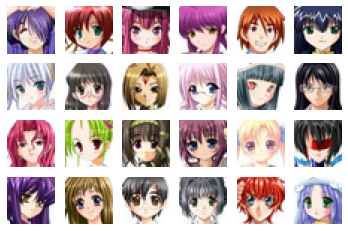

In [7]:
#Display resized images
fig, axs = plt.subplots(4,6)
for i in range(4*6):
    ax = plt.subplot(4,6,i+1)
    ax.imshow(data[i][:,:,:])
    ax.axis("off")

Convert to tf.tensor() object

In [8]:
%%time
data_rescale = tf.convert_to_tensor(data_rescale, dtype=tf.float32)

Wall time: 40.7 s


Split the data for train/test

This is an important step!
> Define the Batch_size of your data set otherwise Keras will run into a ndim error as shown below:

```
ValueError: Input 0 of layer sequential_50 is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: [32, 32, 3]
```

> In the discriminator we define "input_shape = (32,32,3)" however keras actually will have shape (None,32,32,3) where "NONE" is the batch_size.

> By defining our tf.tensor() object as having a batch_size variable ... it'll mini-batch and correctly provide the (256,32,32,3) size to match the keras layers

In [9]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(data_rescale).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Create Generator

In [10]:
def Generator():
    model = tf.keras.Sequential() #Initialize

    #First layer = Dense
    model.add(layers.Dense(8*8*256,use_bias=False,input_shape=(100,))) #Where the noise will feed in

    #Reshape the Dense layer into an image
    model.add(layers.Reshape((8, 8, 256)))

    #Conv2D layer1 --- Scale from 8x8x256 to 8x8x128
    model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    #Conv2D layer2 --- Scale from 8x8x128 to 16x16x64 (Strides (2,2 multiplies by 2))
    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    #Finalize img shape to 3 channels ---- Scale from 16x16x64 to 32x32x3
    model.add(layers.Conv2DTranspose(3,(5,5),strides=(2,2),padding='same',use_bias=False,activation='tanh'))
    #assert model.output_shape == (None,32,32,3)
    
    return model

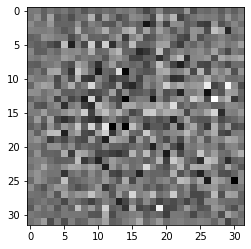

(1, 32, 32, 3)


In [11]:
generator = Generator()

noise = tf.random.normal([1, 100]) #Generate noise
generated_image = generator(noise)

plt.imshow(generated_image[0][:,:,0].numpy(),cmap='gray')
plt.show()

from numpy import save
save("array.npy",generated_image)
print(generated_image.shape)

Create Discriminator

In [12]:
def Discriminator():
    model = tf.keras.Sequential() #Initialize
    
    #32x32x3 --> 64x64x64
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=(32, 32, 3)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    #64x64x64 --> 128x128x128
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    #128x128x128 --> 524,288
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [13]:
discriminator = Discriminator()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00264005]], shape=(1, 1), dtype=float32)


Define loss functions

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) #Loss function is a binary decision

In [15]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [16]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Define Optimization function

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

Create training model checkpoints

In [18]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [40]:
EPOCHS = 15
noise_dim = 100
num_examples_to_generate = 16

# Define seed via hyperparameters to reuse 
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [36]:
@tf.function
def train_step(images):
    '''
    1 single Epoch of work
    '''
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True) #Create noise

        real_output = discriminator(images, training=True) #Pass real image to discriminator
        fake_output = discriminator(generated_images, training=True) #Pass fake image to discriminator

        gen_loss = generator_loss(fake_output) #Compute Generator loss
        disc_loss = discriminator_loss(real_output, fake_output) #Compute Discriminator loss

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) #Update Generator gradient
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables) #Update Discriminator gradient

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) #Update weights
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) #Update weights

In [37]:
import time
def train(dataset, epochs):
    for epoch in range(epochs): 
        start = time.time() #Compute time of each epoch
        for image_batch in dataset: 
            train_step(image_batch) #Train on each image in batch

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every X epochs
        X = 15
        if (epoch + 1) % X == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

In [38]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        #plt.imshow(predictions[i, :, :,0]* 127.5 + 127.5,)
        plt.imshow((predictions[i]*127.5 + 127.5).numpy().astype('uint8'))
        plt.axis('off')

    from numpy import save
    save('epoch_array{:04d}.npy'.format(epoch),predictions)
        
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

Train the model

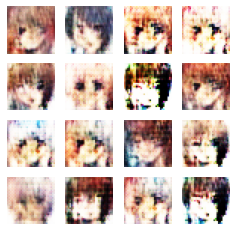

Wall time: 2min 10s


In [43]:
%%time
train(train_dataset, EPOCHS)

Load back one of the epoch images just to view

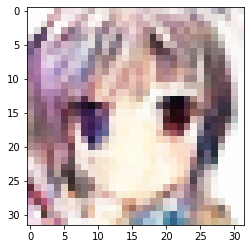

In [39]:
a = np.load("epoch_array0200.npy")
b = a[1]*127.5 + 127.5
plt.imshow(b.astype('uint8'))